# 21cmEMUv2: Adding Radio Background

In this tutorial we demonstrate how to use the emulator that was trained on a 21cmFAST model which includes a radio background (see Cang+24 for more details).

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from matplotlib import rcParams
rcParams.update({'font.size': 12})

from py21cmemu import Emulator
from corner import corner

We begin by loading a database of summaries to use as examples in this tutorial. \
This database is a fraction of the test set of the emulator.

In [2]:
with np.load('Radio_Test_data_sample.npz') as f:
    test_params = f['params']
    test_Tb = f['Tb']
    test_Tr = f['Tr']
    test_PS = f['PS']
    test_xHI = f['xHI']
    test_tau = f['tau']
    PS_k = f['PS_k']
    PS_z = f['PS_z']
    test_z = f['redshifts']
    zs = f['redshifts']

To load the radio emulator, we just need to specify `emulator="radio_background"` when initialising the `Emulator` class.\
If no `emulator` is specified, then the default emulator is loaded.

In [3]:
emu = Emulator(emulator="radio_background")

After initialising the `Emulator` class correctly, the rest of the calls are exactly the same as for the default emulator:

In [4]:
normed_input_params, output, output_errors = emu.predict(test_params)

The outputs can be accessed in the same way as for the default emulator:

In [5]:
print("Summaries returned by the radio_background emulator are: ", list(output.keys()))
print("Shape of radio background temperature summary output: [Nsamples, N redshift bins] = ", output.Tr.shape)

Summaries returned by the radio_background emulator are:  ['Tb', 'xHI', 'Tr', 'PS', 'tau']
Shape of radio background temperature summary output: [Nsamples, N redshift bins] =  (1000, 103)


Just like for the default emulator, we can also input normalised parameters directly:

In [6]:
limits = output.properties.limits

In [7]:

normed_params = (test_params - limits[:,0])/(limits[:,1] - limits[:,0])
normed_input_params, output1, output_errors = emu.predict(test_params)

Check that the emulator prediction is exactly the same whether we input normalised parameters or not:

In [8]:
np.allclose(output.PS, output1.PS)

True

Let's make some plots to compare them. \
We start by defining a function to calculate the fractional error (FE).

In [9]:
# Calculate fractional error (FE)
def print_fe(pred, true, name="", ret = False, floor = None):
    if floor is not None:
        m = abs(true) < floor
        true_final = true.copy()
        true_final[m] = floor
    else:
        true_final = true

    frac_err = abs((pred - true) / true_final) * 100.
    print('FE (%) ' + name + ': Median: %.4f, 68%%CI: %.4f, 95%%CI: %.4f'% tuple(np.nanpercentile(frac_err, [50,84,97.5])))
    print('Abs diff ' + name + ': Median: %.5f, 68%%CI: %.5f, 95%%CI: %.5f'% tuple(np.nanpercentile(abs(pred-true), [50,84,97.5])))
   
    print('FE ' + name + ' STD: %.3f' %np.nanstd(frac_err) )
    if ret:
        return frac_err

First, we can look at the parameter distribution of the test set sample provided:

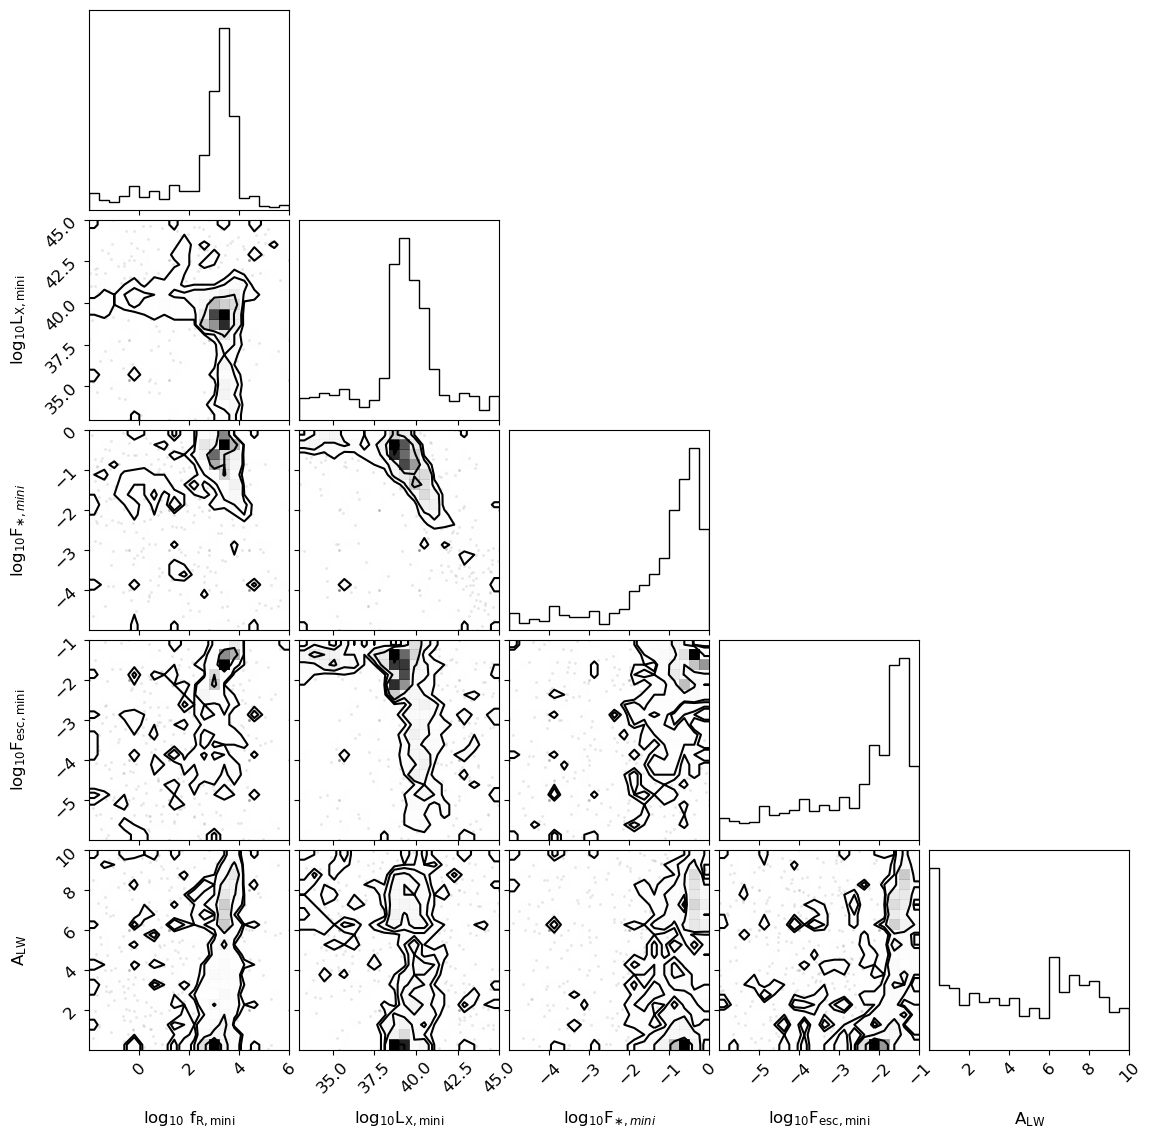

In [11]:
labels = output.properties.parameter_labels
corner(test_params, labels=labels)
plt.show()


Next, we can calculate the emulator performance (fractional error) on each summary and display the median, 68\%, and 95\% confidence limits:

In [12]:
# print performance
Tb_frac_err = print_fe(output.Tb, test_Tb, name="Tb", ret=True, floor = 5)

FE (%) Tb: Median: 2.4298, 68%CI: 9.1370, 95%CI: 29.9726
Abs diff Tb: Median: 0.46664, 68%CI: 3.01442, 95%CI: 14.78150
FE Tb STD: 11.082


In [13]:
Tr_frac_err = print_fe(output.Tr, test_Tr, name = "Tr", ret = True, floor = 1e-4)

FE (%) Tr: Median: 1.3364, 68%CI: 4.7003, 95%CI: 99.9828
Abs diff Tr: Median: 0.79453, 68%CI: 9.19828, 95%CI: 35.84473
FE Tr STD: 22.876


In [14]:
xHI_frac_err = print_fe(output.xHI, test_xHI, name = "xHI", ret = True, floor = 1e-3)

FE (%) xHI: Median: 0.1890, 68%CI: 11.3611, 95%CI: 71.3078
Abs diff xHI: Median: 0.00030, 68%CI: 0.00162, 95%CI: 0.00793
FE xHI STD: 67.385


In [15]:
PS_frac_err = print_fe(output.PS, test_PS, name = "PS", ret = True, floor = 1e-2)

FE (%) PS: Median: 3.4283, 68%CI: 17.7266, 95%CI: 69.1445
Abs diff PS: Median: 0.03751, 68%CI: 27.25376, 95%CI: 6927.05156
FE PS STD: 59.203


In [16]:
tau_frac_err = print_fe(output.tau, test_tau, name = "tau", ret = True)

FE (%) tau: Median: 0.2742, 68%CI: 0.7194, 95%CI: 1.6971
Abs diff tau: Median: 0.00032, 68%CI: 0.00085, 95%CI: 0.00211
FE tau STD: 0.526


We calculate the absolute errors of each summary for the plots:

In [17]:
xHI_diff = abs((output.xHI - test_xHI))
diff_err_xHI_z = np.nanpercentile(xHI_diff, [2.5, 16,50, 84, 97.5], axis = 0)

PS_diff = abs((output.PS - test_PS))
diff_err_PS_z = np.nanpercentile(PS_diff, [2.5, 16,50, 84, 97.5], axis = 0)

Tb_diff = abs((output.Tb - test_Tb))
diff_err_Tb_z = np.nanpercentile(Tb_diff, [2.5, 16,50, 84, 97.5], axis = 0)

Tr_diff = abs((output.Tr - test_Tr))
diff_err_Tr_z = np.nanpercentile(Tr_diff, [2.5, 16,50, 84, 97.5], axis = 0)

tau_diff = abs((output.tau - test_tau))

Let's shuffle the parameters and plot `N = 10` examples at a time. \
The seed is set to 42 for reproducibility.

In [18]:
idxs = np.arange(test_tau.shape[0])
np.random.seed(42)
np.random.shuffle(idxs)

In [19]:
N = 10
idxs = idxs[:N]

In [20]:
cs = ['r', 'g', 'b', 'lime', 'cyan', 'orange', 'k', 'tan', 'firebrick', 'magenta']

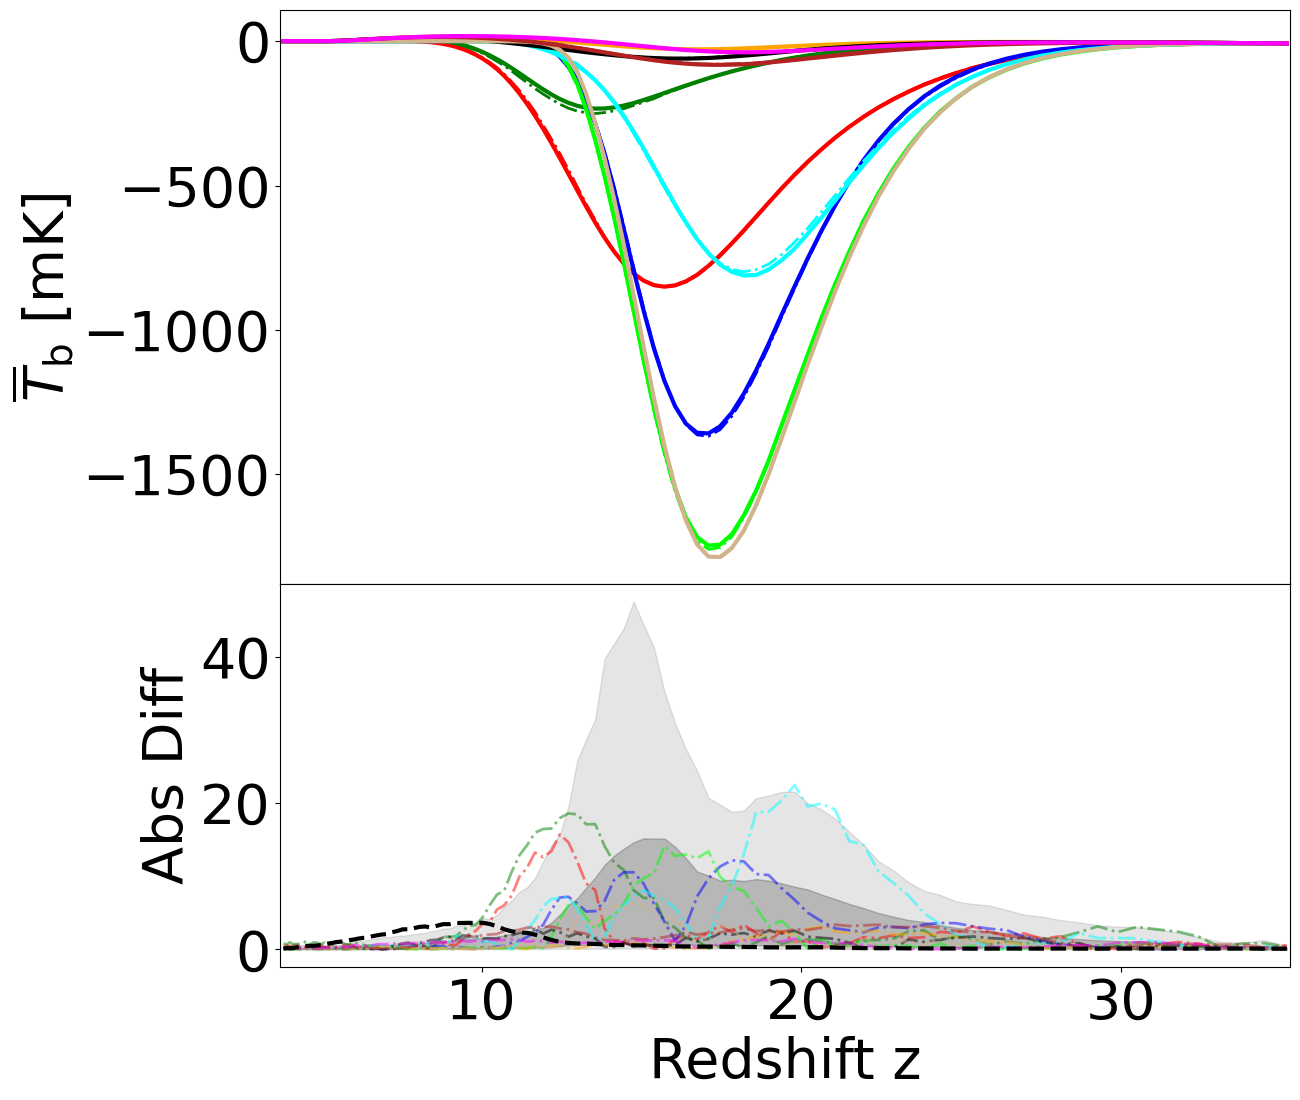

In [21]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

# inset axes...
#axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c in zip(idxs, cs):
    if i == N-1:
        labels = ['21cmEMU', 'Test Set']
    else:
        labels = [None, None]
    axs[0].plot(zs, test_Tb[i, :], lw = 3, color = c, label = labels[1])
    axs[1].plot(zs, Tb_diff[i, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(zs, output.Tb[i, :], lw = 2, ls = '-.', color = c, label = labels[0])

axs[1].plot(zs, diff_err_Tb_z[2, :][::-1], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(zs, diff_err_Tb_z[1, :], diff_err_Tb_z[3, :], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(zs, diff_err_Tb_z[0, :], diff_err_Tb_z[4, :], color = 'k', alpha = 0.1, label = r'95% CI')


axs[0].set_ylabel(r'$\overline{T}_{\rm{b}}$ [mK]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')
axs[1].tick_params(axis='both', which='major')
axs[1].tick_params(axis='both', which='minor')
axs[0].tick_params(axis='y', which='major')
axs[0].tick_params(axis='y', which='minor')
axs[0].set_xlim(zs[0]-0.1, zs[-1]+0.1)

plt.tight_layout()
plt.show()

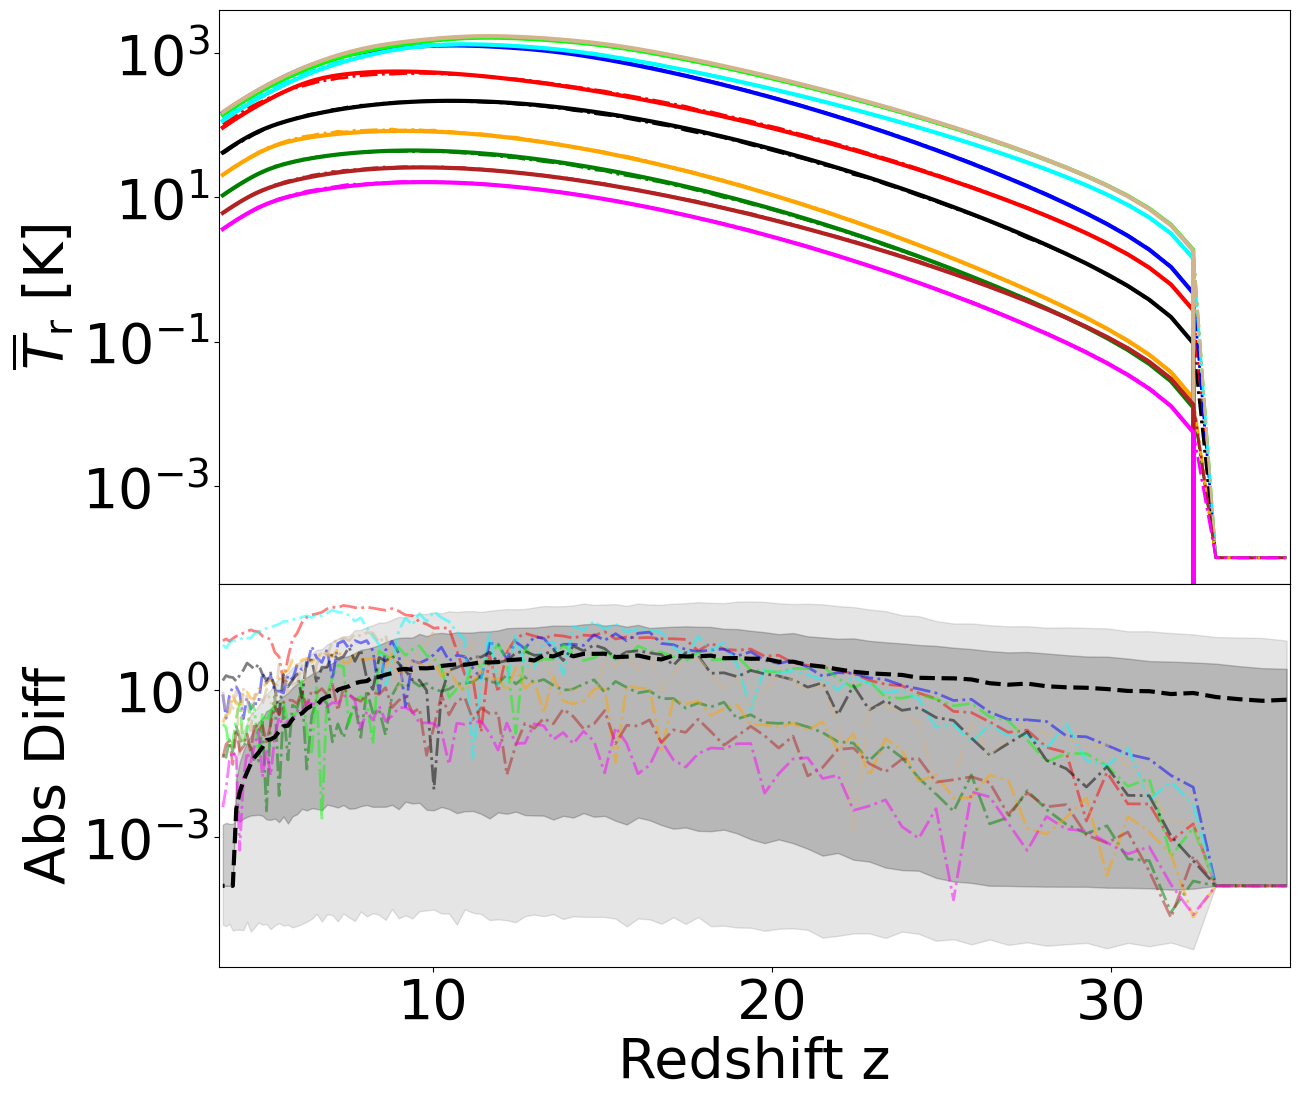

In [22]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

for i, c in zip(idxs, cs):
    if i == N-1:
        labels = ['21cmEMU', 'Test Set']
    else:
        labels = [None, None]
    axs[0].plot(zs, test_Tr[i, :], lw = 3, color = c, label = labels[1])
    axs[1].plot(zs, Tr_diff[i, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(zs, output.Tr[i, :], lw = 2, ls = '-.', color = c, label = labels[0])

axs[1].plot(zs[::-1], diff_err_Tr_z[2, :], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(zs, diff_err_Tr_z[1, :], diff_err_Tr_z[3, :][::-1], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(zs, diff_err_Tr_z[0, :], diff_err_Tr_z[4, :][::-1], color = 'k', alpha = 0.1, label = r'95% CI')


axs[0].set_ylabel(r'$\overline{T}_{\rm{r}}$ [K]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')
axs[1].tick_params(axis='both', which='major')
axs[1].tick_params(axis='both', which='minor')
axs[0].tick_params(axis='y', which='major')
axs[0].tick_params(axis='y', which='minor')
axs[0].set_xlim(zs[0]-0.1, zs[-1]+0.1)
axs[0].set_yscale('log')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

As you can see, for the radio background temperature, the emulator output wiggles around the correct value. \
This behaviour is known. However, it wouldn't significantly affect the result of an inference (as it does not bias the result in any way).

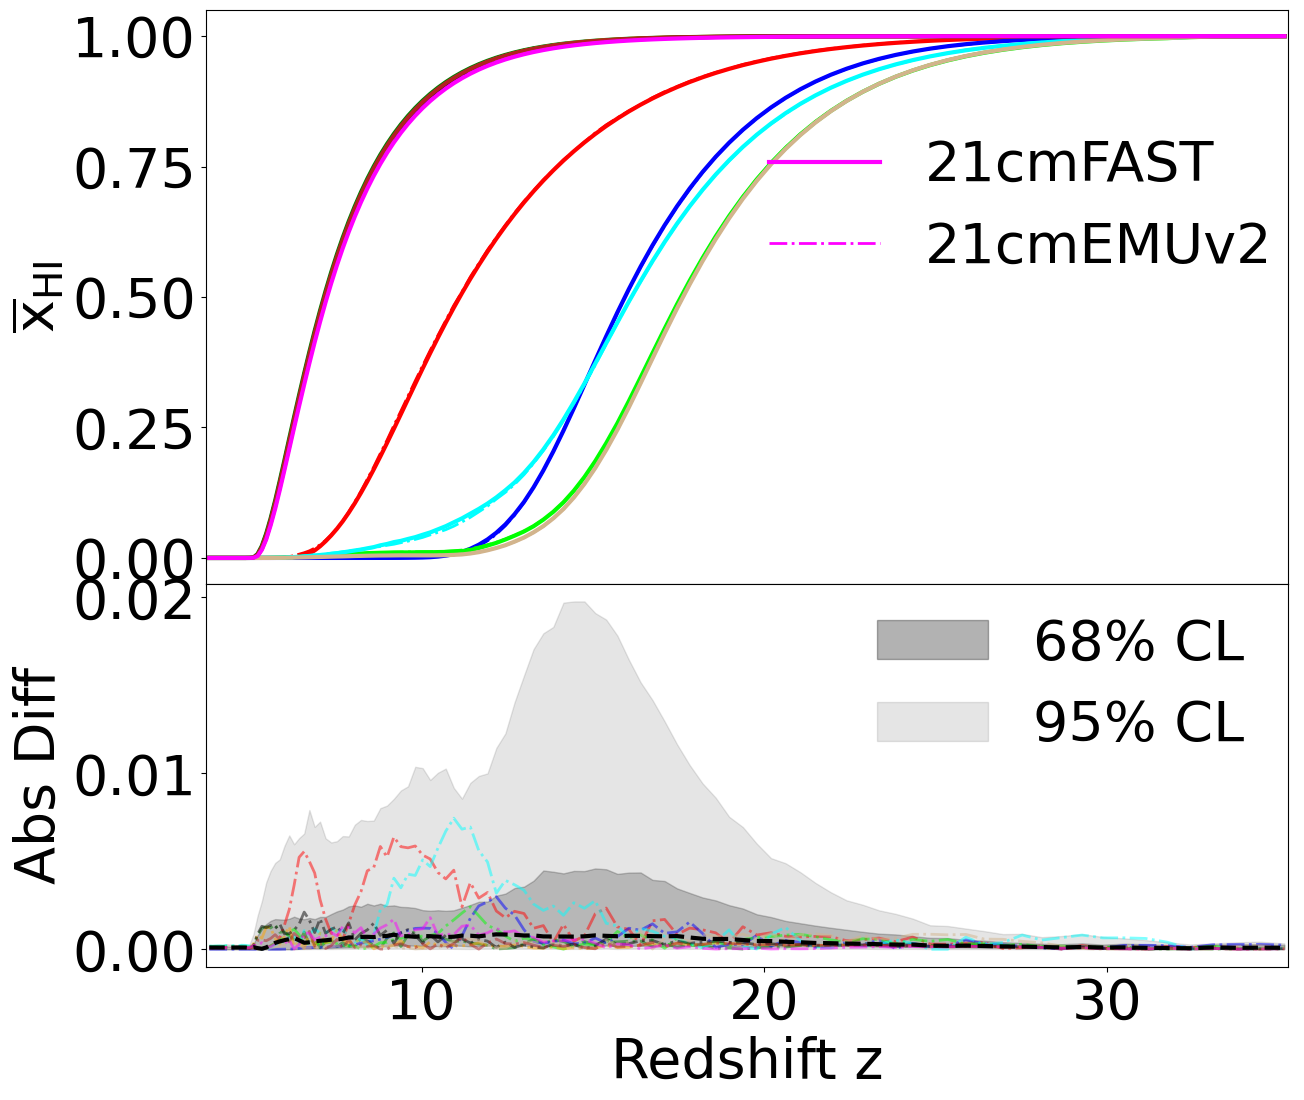

In [23]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

# inset axes...
# axins = axs[1].inset_axes([0.35, 0.2, 0.6, 0.47])

for i, c, num in zip(idxs, cs, range(N)):
    if num == N-1:
        labels = ['21cmEMUv2', '21cmFAST']
    else:
        labels = [None, None]
    axs[0].plot(zs, test_xHI[i, :], lw = 3, color = c, label = labels[1])
    axs[1].plot(zs, xHI_diff[i, :], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(zs, output.xHI[i, :], lw = 2, ls = '-.', color = c, label = labels[0])

axs[0].legend(loc = (0.5,0.5), frameon = False)#framealpha=0.3)
axs[1].plot(zs,diff_err_xHI_z[2, :], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(zs, diff_err_xHI_z[1, :], diff_err_xHI_z[3, :], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(zs, diff_err_xHI_z[0, :], diff_err_xHI_z[4, :], color = 'k', alpha = 0.1, label = r'95% CI')

handles = [mpatches.Patch(color='k', label='68% CL', alpha = 0.3),
          mpatches.Patch(color='k', label='95% CL', alpha = 0.1),
          ]
plt.legend(handles=handles, loc = (0.6,0.5), frameon = False)
axs[0].set_ylabel(r'$\overline{\mathrm{x}}_{\rm{HI}}$')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')

plt.xlim(zs[0]-0.1, zs[-1]+0.1)

plt.tight_layout()
plt.show()

We plot the redshift evolution of the 21-cm power spectrum around scales $k \sim 0.1 \rm{Mpc}^{-1}$:

In [24]:
kbin = 11
PS_k[kbin]

0.10969735366408447

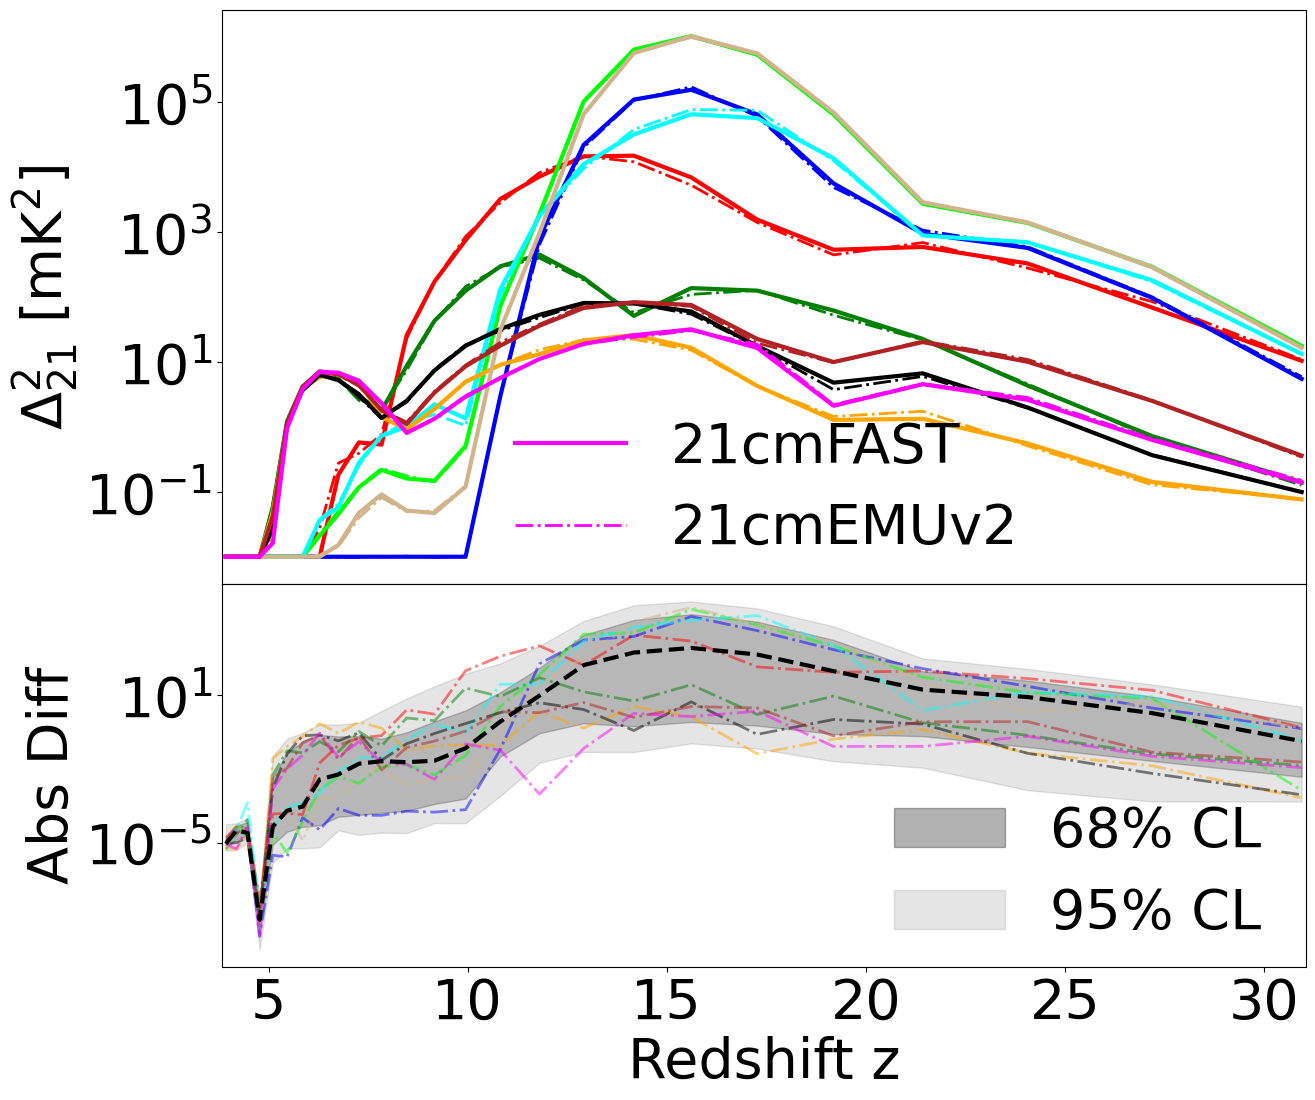

In [25]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()


for i, c, num in zip(idxs, cs, range(N)):
    if num == N-1:
        labels = ['21cmEMUv2', '21cmFAST']
    else:
        labels = [None, None]
    axs[0].plot(PS_z, test_PS[i, :, kbin], lw = 3, color = c, label = labels[1])
    axs[1].plot(PS_z, PS_diff[i, :, kbin], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(PS_z, output.PS[i, :, kbin], lw = 2, ls = '-.', color = c, label = labels[0])

axs[0].legend(loc = (0.25,0.01), frameon = False)#framealpha=0.3)
axs[1].plot(PS_z,diff_err_PS_z[2, :, kbin], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(PS_z, diff_err_PS_z[1, :, kbin], diff_err_PS_z[3, :, kbin], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(PS_z, diff_err_PS_z[0, :, kbin], diff_err_PS_z[4, :, kbin], color = 'k', alpha = 0.1, label = r'95% CI')

handles = [mpatches.Patch(color='k', label='68% CL', alpha = 0.3),
          mpatches.Patch(color='k', label='95% CL', alpha = 0.1),
          ]
plt.legend(handles=handles, loc = (0.6,0.01), frameon = False)
axs[0].set_ylabel(r'$\Delta_{21}^2$ [mK$^2$]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'Redshift z')

axs[0].set_yscale('log')
axs[1].set_yscale('log')

plt.xlim(PS_z[0]-0.1, PS_z[-1]+0.1)

plt.tight_layout()
plt.show()

Now we plot the 21-cm power spectrum evolution at a fixed redshift of about $z \sim 8.5$.

In [27]:
zbin = 11
PS_z[zbin]

8.46594037485638

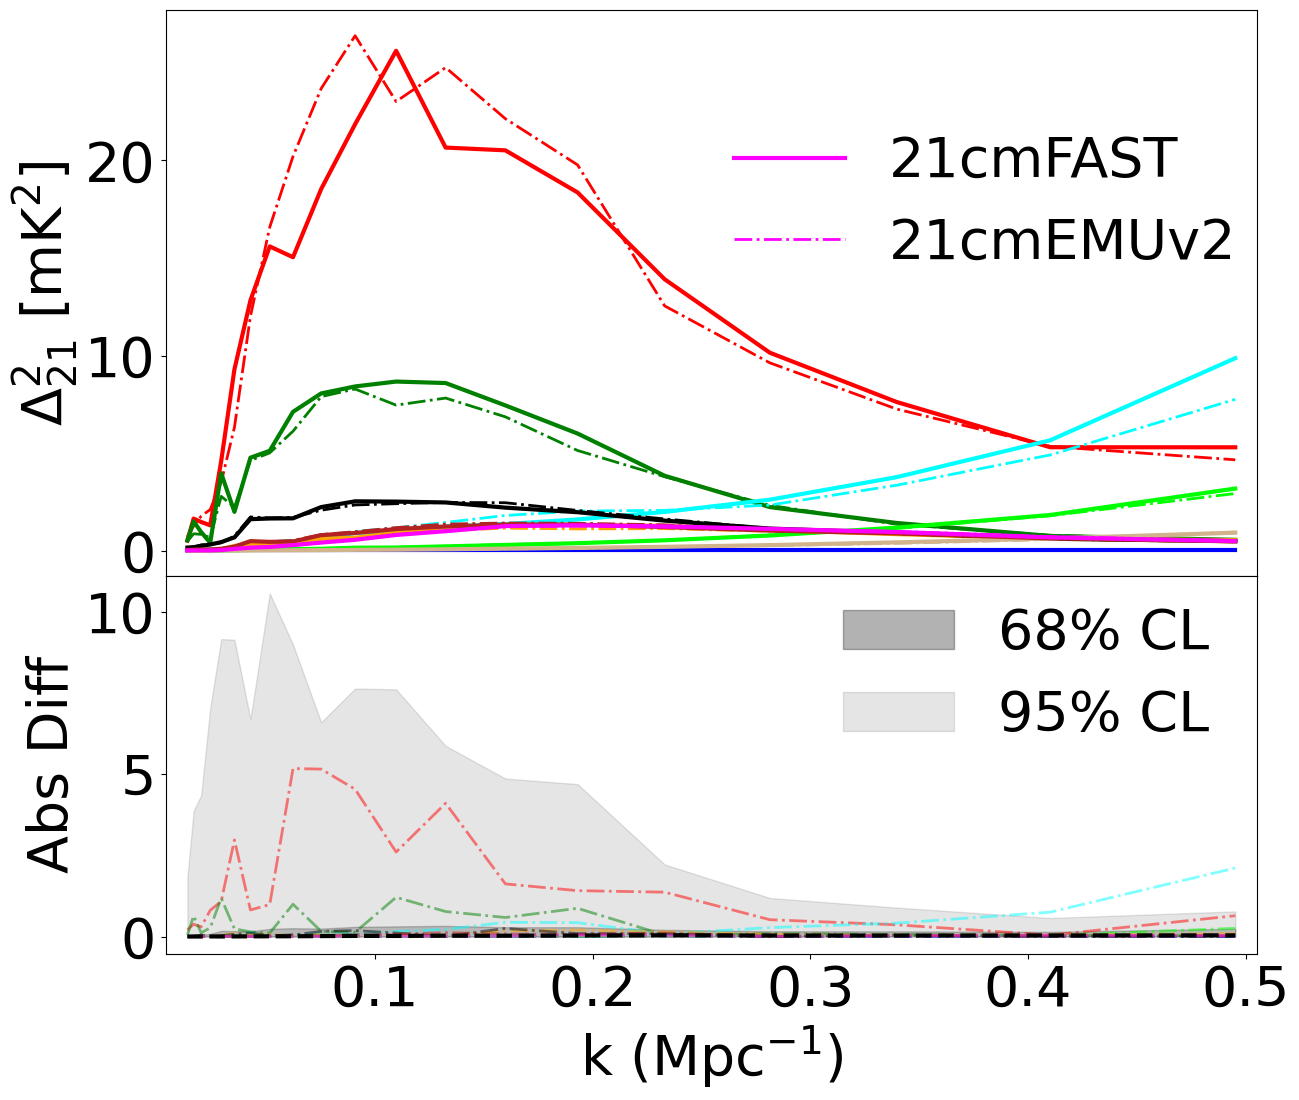

In [28]:
rcParams.update({'font.size': 40})

fig, axs = plt.subplots(nrows = 2, ncols = 1, sharex = True,figsize = (14,12), gridspec_kw=dict(height_ratios=[3,2], hspace=0))
axs = axs.flatten()

for i, c, num in zip(idxs, cs, range(N)):
    if num == N-1:
        labels = ['21cmEMUv2', '21cmFAST']
    else:
        labels = [None, None]
    axs[0].plot(PS_k, test_PS[i, zbin,:], lw = 3, color = c, label = labels[1])
    axs[1].plot(PS_k, PS_diff[i, zbin,:], ls = '-.', alpha = 0.5, lw = 2, color = c)
    axs[0].plot(PS_k, output.PS[i, zbin,:], lw = 2, ls = '-.', color = c, label = labels[0])

axs[0].legend(loc = (0.5,0.5), frameon = False)#framealpha=0.3)
axs[1].plot(PS_k,diff_err_PS_z[2, zbin,:], ls = '--', lw = 3, color = 'k', label = r'Median')
axs[1].fill_between(PS_k, diff_err_PS_z[1, zbin,:], diff_err_PS_z[3, zbin,:], color = 'k', alpha = 0.2, label = r'68% CI')
axs[1].fill_between(PS_k, diff_err_PS_z[0, zbin,:], diff_err_PS_z[4, zbin,:], color = 'k', alpha = 0.1, label = r'95% CI')
#axins.plot(zs, err_xHI_z[1, :], ls = '--', lw = 3, color = 'k', label = r'$x_{\rm{HI}}$ Median')
#axins.fill_between(zs, err_xHI_z[0, :], err_xHI_z[2, :], color = 'k', alpha = 0.3, label = r'$x_{\rm{HI}}$ 68% CI')

handles = [mpatches.Patch(color='k', label='68% CL', alpha = 0.3),
          mpatches.Patch(color='k', label='95% CL', alpha = 0.1),
          ]
plt.legend(handles=handles, loc = (0.6,0.5), frameon = False)
axs[0].set_ylabel(r'$\Delta_{21}^2$ [mK$^2$]')
axs[1].set_ylabel(r'Abs Diff')
axs[1].set_xlabel(r'k (Mpc$^{-1}$)')

plt.xlim(PS_k[0]-1e-2, PS_k[-1]+1e-2)

plt.tight_layout()
plt.show()

In [31]:
tau_bins = np.linspace(min(test_tau), np.percentile(test_tau, 99.), 15)
tau_binned_fe = np.zeros(len(tau_bins))
tau_binned_fe_68 = np.zeros((len(tau_bins),2))
tau_binned_fe_95 = np.zeros((len(tau_bins),2))

In [32]:
for i in range(len(tau_bins)-1):
    mask = np.logical_and(test_tau >= tau_bins[i], test_tau < tau_bins[i+1])
    low1, low, med, high, high1 = (np.nanpercentile(tau_frac_err[mask], [2.5, 16,50,84, 97.5]))
    tau_binned_fe[i] = med
    tau_binned_fe_68[i,:] = [low, high]
    tau_binned_fe_95[i,:] = [low1, high1]

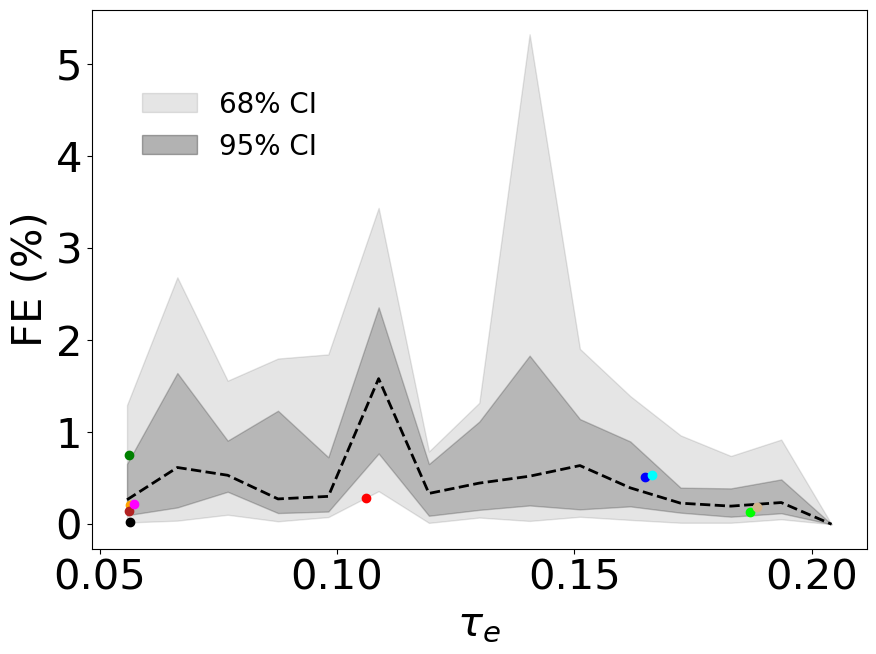

In [33]:
plt.figure(figsize=(10,7))
rcParams.update({'font.size': 30})
plt.plot(tau_bins, tau_binned_fe, color = 'k', lw = 2, ls = '--')
plt.fill_between(tau_bins, tau_binned_fe_68[:,0], tau_binned_fe_68[:,1], color = 'k', alpha = 0.2)
plt.fill_between(tau_bins, tau_binned_fe_95[:,0], tau_binned_fe_95[:,1], color = 'k', alpha = 0.1)

for i in range(N):
    plt.scatter(output.tau[idxs[i]], tau_frac_err[idxs[i]], color = cs[i], marker = 'o', zorder = 2)
plt.xlabel(r'$\tau_e$')
handles = [mpatches.Patch(color='k', label='68% CI', alpha = 0.1),
          mpatches.Patch(color='k', label='95% CI', alpha = 0.3),
          ]
plt.legend(handles=handles, loc = (0.05,0.7), frameon = False, fontsize = 20)
plt.ylabel('FE (%)')
plt.show()